In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import os
import cv2 as cv
import numpy as np
import tqdm

from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

In [24]:
IMAGES_PATH = Path('drive') / 'MyDrive' / 'Kvasir-SEG' / 'images'
MASKS_PATH = Path('drive') / 'MyDrive' / 'Kvasir-SEG' / 'masks'

In [32]:
images_paths = sorted([IMAGES_PATH / file_name for file_name in os.listdir(IMAGES_PATH)])
masks_paths = sorted([MASKS_PATH / file_name for file_name in os.listdir(MASKS_PATH)])

print(images_paths[:3])
print(masks_paths[:3])

[PosixPath('drive/MyDrive/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg'), PosixPath('drive/MyDrive/Kvasir-SEG/images/cju0qoxqj9q6s0835b43399p4.jpg'), PosixPath('drive/MyDrive/Kvasir-SEG/images/cju0qx73cjw570799j4n5cjze.jpg')]
[PosixPath('drive/MyDrive/Kvasir-SEG/masks/cju0qkwl35piu0993l0dewei2.jpg'), PosixPath('drive/MyDrive/Kvasir-SEG/masks/cju0qoxqj9q6s0835b43399p4.jpg'), PosixPath('drive/MyDrive/Kvasir-SEG/masks/cju0qx73cjw570799j4n5cjze.jpg')]


In [33]:
def show_imgs(imgs):
    fig, axs = plt.subplots(1, len(imgs), figsize=(10, 5))

    if len(imgs) == 1:
        axs = [axs]

    [axs[i].imshow(cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB)) for i in range(len(imgs))]

    plt.tight_layout()

    plt.show()

In [34]:
SIZE = 256


def read_img(path, gray=False):
    img = cv.imread(str(path), cv.IMREAD_GRAYSCALE if gray else cv.IMREAD_UNCHANGED)
    img = cv.resize(img, (SIZE, SIZE))
    if gray:
        img = (img > 127).astype(np.uint8)

    return img

In [35]:
def combine_img_width_msk(img, msk, line_intensity=0):
    edge = cv.Canny(msk, 30, 100)
    combined_img = img.copy()
    combined_img[edge == 255] = line_intensity
    return combined_img

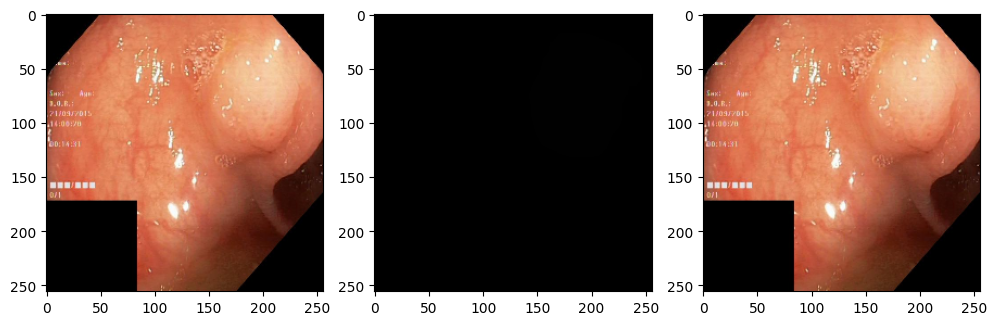

In [36]:
img = read_img(images_paths[24])
msk = read_img(masks_paths[24], gray=True)
combined = combine_img_width_msk(img, msk)
show_imgs([img, msk, combined])

In [37]:
X_train_paths, X_test_paths, y_train_paths, y_test_paths = train_test_split(
    images_paths, masks_paths, test_size=0.1, random_state=1
)

X_train_paths, X_val_paths, y_train_paths, y_val_paths = train_test_split(
    X_train_paths, y_train_paths, test_size=0.1, random_state=1
)

print(
    " X_train_paths:",
    len(X_train_paths),
    " y_train_paths:",
    len(y_train_paths),
    " X_val_paths:",
    len(X_val_paths),
    " y_val:_paths",
    len(y_val_paths),
    " X_test_paths:",
    len(X_test_paths),
    " y_test_paths:",
    len(y_test_paths),
)

 X_train_paths: 810  y_train_paths: 810  X_val_paths: 90  y_val:_paths 90  X_test_paths: 100  y_test_paths: 100


100%|██████████| 100/100 [00:00<00:00, 151.69it/s]


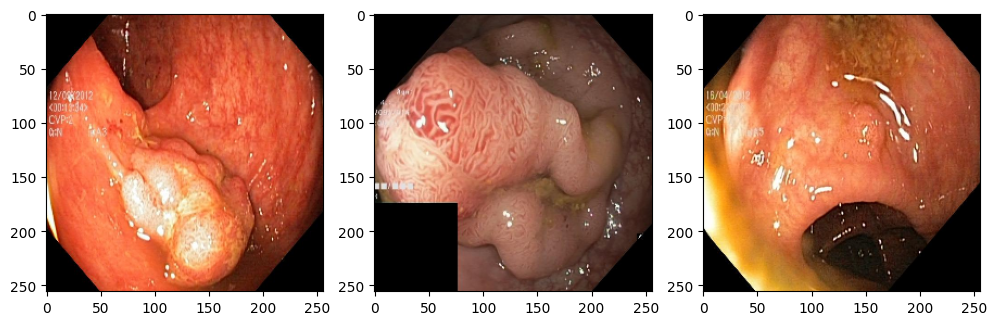

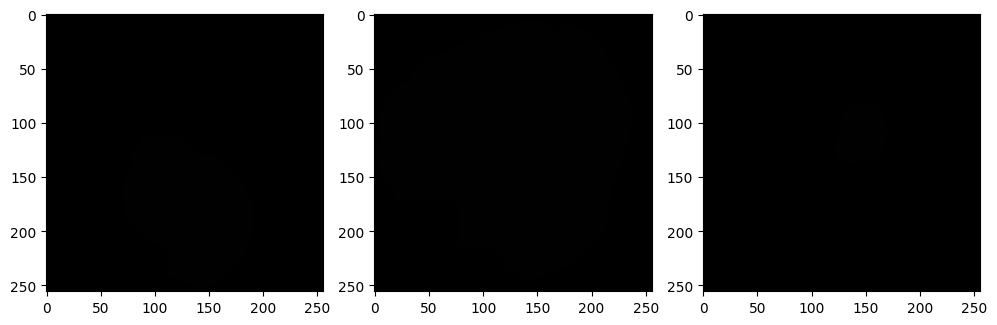

In [39]:
X_train = np.array([read_img(path) for path in tqdm.tqdm(X_train_paths)])
y_train = np.array([read_img(path, gray=True) for path in tqdm.tqdm(y_train_paths)])
X_val = np.array([read_img(path) for path in tqdm.tqdm(X_val_paths)])
y_val = np.array([read_img(path, gray=True) for path in tqdm.tqdm(y_val_paths)])
X_test = np.array([read_img(path) for path in tqdm.tqdm(X_test_paths)])
y_test = np.array([read_img(path, gray=True) for path in tqdm.tqdm(y_test_paths)])

show_imgs([X_train[0], X_val[0], X_test[0]])
show_imgs([y_train[0], y_val[0], y_test[0]])

# Defining Model

In [41]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [51]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Concatenate, Conv2DTranspose
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [43]:
def unet_model(output_channels):
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    base_model = MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(output_channels, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [44]:
model = unet_model(2)
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


# Training

In [46]:
EPOCHS = 5

model_history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=16,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/5
51/51 [==============================] - 6s 107ms/step - loss: 0.2989 - accuracy: 0.8751 - val_loss: 0.5359 - val_accuracy: 0.7327
Epoch 2/5
51/51 [==============================] - 5s 107ms/step - loss: 0.2989 - accuracy: 0.8748 - val_loss: 0.3695 - val_accuracy: 0.8332
Epoch 3/5
51/51 [==============================] - 5s 107ms/step - loss: 0.2934 - accuracy: 0.8776 - val_loss: 0.3495 - val_accuracy: 0.8519
Epoch 4/5
51/51 [==============================] - 5s 108ms/step - loss: 0.2926 - accuracy: 0.8772 - val_loss: 0.3678 - val_accuracy: 0.8596
Epoch 5/5
51/51 [==============================] - 6s 109ms/step - loss: 0.2900 - accuracy: 0.8788 - val_loss: 0.3431 - val_accuracy: 0.8532


In [ ]:
model.save('./models/polyp-segm-10e')

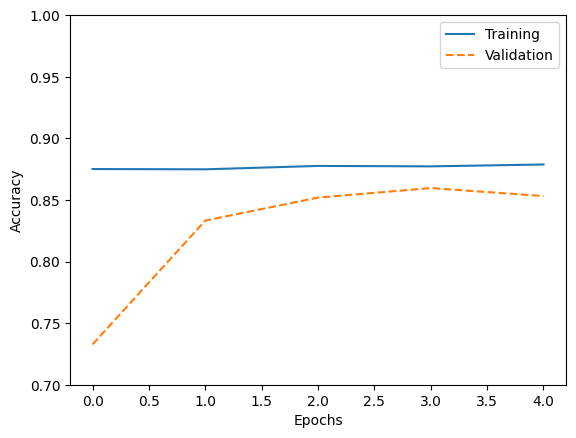

In [47]:
history_1 = model_history.history
acc=history_1['accuracy']
val_acc = history_1['val_accuracy']



plt.plot(acc[:150], '-', label='Training')
plt.plot(val_acc[:150], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1.0])
plt.legend()
plt.show()

# Results

In [62]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

1/1 [==============================] - 0s 37ms/step


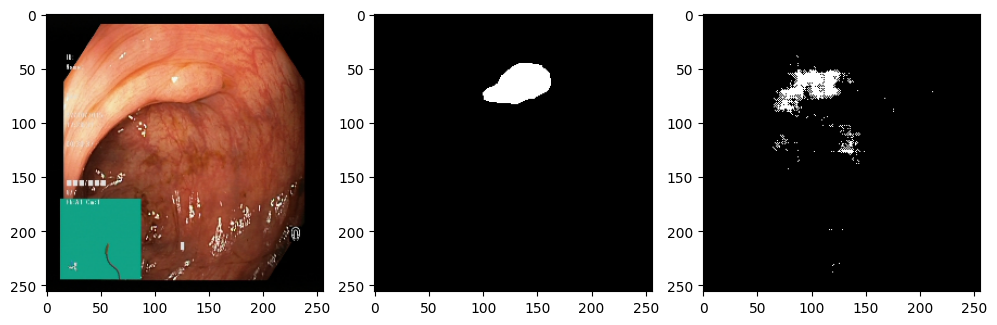

In [93]:
index = 20
img = X_train[index]
msk = y_train[index]
msk[msk==1] = 255
res = np.array(create_mask(model.predict(img[tf.newaxis, ...])))
res = np.squeeze(res).astype(np.uint8)
res[res==1] = 255

show_imgs([img, msk, res])